In [1]:
csv_path = '../../data/raw/csvs/dayli.csv'

In [2]:
pwd

'/home/emanuel/projects/tesis-grado/emanuel/sna-famaf/notebook/eda'

In [3]:
import pandas as pd
import pickle
# from db import DBHandler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%%time

dtypes = {
    'user.id_str': str,
    'id_str': str,
    'text': str,
    'retweeted_status.id_str': str ,
    'retweeted_status.user.id_str': str,
    'retweet_count': int,
    'quoted_status_id_str': str,
}
df = pd.read_csv(csv_path, dtype=dtypes, encoding='utf-8')

# parse dates
datetime_cols = [c for c in df.columns if 'created_at' in c]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c])

# reemplazar nombre de columnas: . por __ para sintactic sugar de pandas.
df.rename(columns=lambda x: x.replace('.', '__'), inplace=True)

CPU times: user 48.4 s, sys: 128 ms, total: 48.5 s
Wall time: 48.5 s


In [5]:
df.tail()

,created_at,user__id_str,id_str,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str
145584,2018-10-30 07:45:34,10909852,1057176672275980288,NaN,NaN,NaT,0,1057175557266423808
145585,2018-10-30 07:41:08,10909852,1057175557266423808,NaN,NaN,NaT,0,NaN
145586,2018-10-30 07:28:17,10909852,1057172323118342144,NaN,NaN,NaT,0,NaN
145587,2018-10-30 07:15:41,10909852,1057169151393972225,NaN,NaN,NaT,0,NaN
145588,2018-10-30 16:10:07,84644827,1057303643836293120,NaN,NaN,NaT,1,NaN


In [ ]:
### READ FROM MONGODB CONNECTION


# h = DBHandler(port=27017)

# columns = ['created_at', 'id_str', 'retweet_count', 'retweeted_status__id_str', 'retweeted_status__created_at']
# separator = '__'
# project = ({f_name: '$' + f_name.replace(separator, '.') for f_name in columns})
# project.update({'retweeted_status': '$retweeted_status.id_str'})


# cursor = h.tweet_collection.aggregate([
#     {'$project': project}
# ])
# df = pd.DataFrame(list(cursor))

# # datatype conversion
# datetime_cols = [c for c in df.columns if 'created_at' in c]
# for c in datetime_cols:
#     df[c] = pd.to_datetime(df[c])

In [8]:
# usefull aliases
def df_only_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.notna()]

def df_not_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.isna()]

def df_commented(data_f):
    return data_f[data_f.quoted_status_id_str.notna()]

### Basic counts

In [9]:
quantity_of_users_on_ds = df.user__id_str.value_counts().count()
quantity_of_tweets_on_ds = df.id_str.value_counts().count()
print('Hay {} usuarios en el dataset.'.format(quantity_of_users_on_ds))
print('Hay {} tweets en el dataset.'.format(quantity_of_tweets_on_ds))

Hay 3730 usuarios en el dataset.
Hay 145587 tweets en el dataset.


# Recorte 1: tomar solo retweets que relacionan nuestros usuarios

Para algunos puntos desarrollados se tendrá en cuenta un recorte de dataset: Éste consiste en tomar, de todos los tweets recogidos, sólo aquellos que relacionan nuestros usuarios considerados para el estudio.

Se usará 'Global' para referirse a la totalidad de los tweets, y 'Recorte 1' para referirse a la selección mencionada.

(Problema 1: el campo retweeted_status devuelve el tweet original, no el tweet que se retweeteo. Es decir que si se trata de un RT de un RT, la relación retweeted_status ignora los intermedios y señala el tweet original.)

## UPDATE: "reciclaje de tweets"

Se van a sumar a este recorte los tweets que hayan sido retweeteados más de una vez en el dataset. En estos casos se toma como tweet original al tweet más temprano en el tiempo de todos los retweeteos entre nuestros usuarios.

In [10]:
### PROTOTYPE-FILTERING

# def _df_cut1(data_f):
#     # el filtro 1 va a ser un gran OR de:
#     # OR item 1: tweets originales en este dataset (que no son RT de nada)
#     data_f = df.copy(deep=True)
#     original_tweets_on_ds = data_f.retweeted_status__id_str.isna()

#     # OR item 2: tweets que son RT de un tweet de nuestros usuarios (un tweet de nuestros usuarios,
#     # es un tweet original en este dataset)
#     retweeted_by_my_users = data_f.retweeted_status__id_str.isin(df.id_str)

#     # OR item 3: tweets que fueron retweeteados mas de 1 vez en este dataset.
#     # para mantener consistencia en esta alteración el campo retweeted_status__created_at debe ser modificado,
#     # usando el timestamp más temprano de los retweets de un mismo tweet.

#     # obtener los conteos de tweets en el dataset
#     rt_counts_on_ds = data_f.groupby(data_f.retweeted_status__id_str).count()
#     # filtrar los tweets que tiene más de un retweet en el ds
#     tweet_ids_w_more_than_one_rt = rt_counts_on_ds[rt_counts_on_ds.retweeted_status__user__id_str > 1]
#     # obtener los ids de dichos tweets
#     tweet_ids_w_more_than_one_rt = list(tweet_ids_w_more_than_one_rt.index)
#     # seleccionar solo los que estan en el filtro
#     tweet_w_more_than_one_rt = data_f.retweeted_status__id_str.isin(tweet_ids_w_more_than_one_rt)
    
    
#     # Ahora vamos a reasignar los valores correctos a retweeted_status__created_at de los tweet_w_more_than_one_rt
#     # para ello se crea un nuevo campo 'retweeted_status__new_created_at'

#     # selecciono solo los tweets que voy a modificar
#     aux_df = data_f[tweet_w_more_than_one_rt]
#     # definimos una serie de pandas que sirve como diccionario: retweeted_status__id_str -> minimo timestamp
#     # en el ds, SOLO para aquellos retweets 'reciclados' en este procesamiento.
#     min_timestamps = aux_df.groupby(aux_df.retweeted_status__id_str).created_at.min()
#     # para setear en data_f el nuevo campo adecuadamente, los NaT deben ser tratados. Se los pasa temporalmente
#     # por un -1 -> nan.
#     min_timestamps.loc['-1'] = np.nan
#     # copiamos la columna retweeted_status__id_str, para reemplazarla por los new_created_at, llenando los NA con -1
#     new_created_at_column = data_f.retweeted_status__id_str.fillna('-1').values
#     # finalmente, pasamos la columna a los timestamps que calculamos, de acuerdo a su retweeted_status__id_str
#     data_f['retweeted_status__new_created_at'] = min_timestamps[new_created_at_column].values
#     # ya tenemos a data_f con los valores "reciclados", pero faltan los originales (rt_status__created_at
#     # que no fueron reciclados)
#     # si la columna nueva es NaT, rellenamos con el valor de retweeted_status__created_at
#     data_f['retweeted_status__new_created_at'] = \
#         data_f.retweeted_status__new_created_at.fillna(data_f.retweeted_status__created_at)

#     # reasignamos los valores con los que vamos a trabajar
#     data_f['retweeted_status__created_at'], data_f['retweeted_status__old_created_at'] = \
#         data_f['retweeted_status__new_created_at'], data_f['retweeted_status__created_at']
#     ### Y el created at también!
#     return data_f[original_tweets_on_ds |retweeted_by_my_users | tweet_w_more_than_one_rt]


### DUDA:
"""
este reciclaje tiene una proporción grande de retweets (en develop: antes se usaban 3% del total de tweets,
con el reciclaje se llega al 16%). Con esto, la mayor parte de nuestros tweets son reciclados,
y si su distribución tiene características diferentes a los tweets originales, no estoy hablano de twitter...
"""
# df_cut1 = _df_cut1(df)

'\neste reciclaje tiene una proporción grande de retweets (en develop: antes se usaban 3% del total de tweets,\ncon el reciclaje se llega al 16%). Con esto, la mayor parte de nuestros tweets son reciclados,\ny si su distribución tiene características diferentes a los tweets originales, no estoy hablano de twitter...\n'

In [11]:
### PROTOTYPE-FILTERING

def _df_cut1(data_f):
    # el filtro 1 va a ser un gran OR de:
    # OR item 1: tweets originales en este dataset (que no son RT de nada)
    data_f = df.copy(deep=True)
    original_tweets_on_ds = data_f.retweeted_status__id_str.isna()

    # OR item 2: tweets que son RT de un tweet de nuestros usuarios (un tweet de nuestros usuarios,
    # es un tweet original en este dataset)
    retweeted_by_my_users = data_f.retweeted_status__id_str.isin(df.id_str)

    # OR item 3: tweets que fueron retweeteados mas de 1 vez en este dataset.
    # para mantener consistencia en esta alteración el campo retweeted_status__created_at debe ser modificado,
    # usando el timestamp más temprano de los retweets de un mismo tweet.

    # obtener los conteos de tweets en el dataset
    rt_counts_on_ds = data_f.groupby(data_f.retweeted_status__id_str).count()
    # filtrar los tweets que tiene más de un retweet en el ds
    tweet_ids_w_more_than_one_rt = rt_counts_on_ds[rt_counts_on_ds.retweeted_status__user__id_str > 1]
    # obtener los ids de dichos tweets
    tweet_ids_w_more_than_one_rt = list(tweet_ids_w_more_than_one_rt.index)
    # seleccionar solo los que estan en el filtro
    tweet_w_more_than_one_rt = data_f.retweeted_status__id_str.isin(tweet_ids_w_more_than_one_rt)


    # Ahora vamos a reasignar los valores correctos a retweeted_status__created_at de los tweet_w_more_than_one_rt
    # para ello se crea un nuevo campo 'retweeted_status__new_created_at'

    # selecciono solo los tweets que voy a modificar
    aux_df = data_f[tweet_w_more_than_one_rt]
    # definimos una serie de pandas que sirve como diccionario: retweeted_status__id_str -> minimo timestamp
    # en el ds, SOLO para aquellos retweets 'reciclados' en este procesamiento.
    min_timestamps = aux_df.loc[aux_df.groupby(aux_df.retweeted_status__id_str).created_at.idxmin()]
    # para setear en data_f el nuevo campo adecuadamente, los NaT deben ser tratados. Se los pasa temporalmente
    # por un -1 -> nan.

    min_timestamps.set_index('retweeted_status__id_str', inplace=True)
    min_timestamps.loc['-1'] = np.nan

    # copiamos la columna retweeted_status__id_str, para reemplazarla por los new_created_at, llenando los NA con -1
    new_created_at_column = data_f.retweeted_status__id_str.fillna('-1').values
    # finalmente, pasamos la columna a los timestamps que calculamos, de acuerdo a su retweeted_status__id_str
    data_f['retweeted_status__new_created_at'] = min_timestamps.loc[new_created_at_column].created_at.values
    # reasignamos valores correctos para los campos retweeted_status__user_id
    data_f['retweeted_status__new_user__id_str'] = min_timestamps.loc[new_created_at_column].user__id_str.values
    # reasignamos valores correctos para los campos retweeted_status__id_str
    data_f['retweeted_status__new_id_str'] = min_timestamps.loc[new_created_at_column].index.values

    # ya tenemos a data_f con los valores "reciclados", pero faltan los originales (rt_status__created_at,
    # rt_status__id_str y rt_status__user_id_str que no fueron reciclados)
    # si la columna nueva de created_at es NaT, rellenamos con el valor de retweeted_status__created_at
    data_f['retweeted_status__new_created_at'] = \
        data_f.retweeted_status__new_created_at.fillna(data_f.retweeted_status__created_at)
    # si la columna nueva de new_id_str es '-1', rellenamos con nan,
    # para luego rellenar con el valor de rt_status__id_str, si se encontro nan
    data_f.retweeted_status__new_id_str = data_f.retweeted_status__new_id_str.replace('-1', value=np.nan)
    data_f['retweeted_status__new_id_str'] = \
        data_f.retweeted_status__new_id_str.fillna(data_f.retweeted_status__id_str)
    # si la columna nueva de new_user__id_str es NaT, rellenamos con el valor de retweeted_status__user__id_str
    data_f['retweeted_status__new_user__id_str'] = \
        data_f.retweeted_status__new_user__id_str.fillna(data_f.retweeted_status__user__id_str)

    # reasignamos los valores con los que vamos a trabajar
    data_f['retweeted_status__created_at'], data_f['retweeted_status__old_created_at'] = \
        data_f['retweeted_status__new_created_at'], data_f['retweeted_status__created_at']
    data_f['retweeted_status__user__id_str'], data_f['retweeted_status__old_user__id_str'] = \
        data_f['retweeted_status__new_user__id_str'], data_f['retweeted_status__user__id_str']
    data_f['retweeted_status__id_str'], data_f['retweeted_status__old_id_str'] = \
        data_f['retweeted_status__new_id_str'], data_f['retweeted_status__id_str']

    return data_f[original_tweets_on_ds |retweeted_by_my_users | tweet_w_more_than_one_rt]


## DUDA:
"""
este reciclaje tiene una proporción grande de retweets (en develop: antes se usaban 3% del total de tweets,
con el reciclaje se llega al 16%). Con esto, la mayor parte de nuestros tweets son reciclados,
y si su distribución tiene características diferentes a los tweets originales,
tal vez no estoy hablando de twitter?
"""
df_cut1 = _df_cut1(df)

/home/emanuel/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/emanuel/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/emanuel/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://panda

### 1 Proporciones de RT sobre tweets totales

In [12]:
def print_dataset_proportions(data_f):
    cant_rt = df_only_rt(data_f).shape[0]
    cant_orig = df_not_rt(data_f).shape[0]
    cant_resp = df_commented(data_f).shape[0]
    total = data_f.shape[0]
    print('Cantidad de tweets originales: \t\t{}'.format(cant_orig))
    print('Cantidad de RT en el Dataset: \t\t{}'.format(cant_rt))
    print('Cantidad de respuestas a tweets: \t{}'.format(cant_resp))
    print('Total: \t\t\t\t\t{}\n'.format(total))
    cants = pd.DataFrame({'cantidades': [cant_orig, cant_rt , cant_resp]},
                         index=['originales', 'retweets', 'respuestas'])
    ax = (cants/1000).plot.bar(y='cantidades', figsize=(5, 5), legend=[])
    ax.set_title('Cantidades de tweets (miles)')

    print('Proporcion de RT sobre total: \t\t\t{}'.format(cant_rt / total))
    print('Proporcion de Tweets originales sobre total: \t{}'.format(cant_orig / total))
    print('Proporcion de Tweets respuestas a tweets sobre total: \t{}\n'.format(cant_resp / total))

    commented_and_retweeted = data_f[(data_f.quoted_status_id_str.notna()) & \
                                     (data_f.retweeted_status__id_str.notna())]\
                                    .shape[0]
    commented_and_not_rt = data_f[(data_f.quoted_status_id_str.notna()) & \
                                  (data_f.retweeted_status__id_str.isna())] \
                                 .shape[0]
    print('Cantidad tweets comentados y retweeteados: \t{}'.format(commented_and_retweeted))
    print('Cantidad tweets comentados y NO retweeteados: \t{}'.format(commented_and_not_rt))
    print('Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!')

### 1.0 Proporciones de RT sobre tweets totales (Global)

Cantidad de tweets originales: 		101979
Cantidad de RT en el Dataset: 		43610
Cantidad de respuestas a tweets: 	11486
Total: 					145589

Proporcion de RT sobre total: 			0.2995418609922453
Proporcion de Tweets originales sobre total: 	0.7004581390077547
Proporcion de Tweets respuestas a tweets sobre total: 	0.07889332298456614

Cantidad tweets comentados y retweeteados: 	4231
Cantidad tweets comentados y NO retweeteados: 	7255
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!


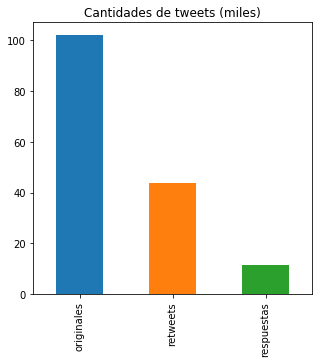

In [13]:
print_dataset_proportions(df)

### 1.1 Proporciones de RT sobre tweets totales (Recorte 1)

Cantidad de tweets originales: 		101979
Cantidad de RT en el Dataset: 		20103
Cantidad de respuestas a tweets: 	9196
Total: 					122082

Proporcion de RT sobre total: 			0.16466801002604806
Proporcion de Tweets originales sobre total: 	0.835331989973952
Proporcion de Tweets respuestas a tweets sobre total: 	0.07532641994724858

Cantidad tweets comentados y retweeteados: 	1941
Cantidad tweets comentados y NO retweeteados: 	7255
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!


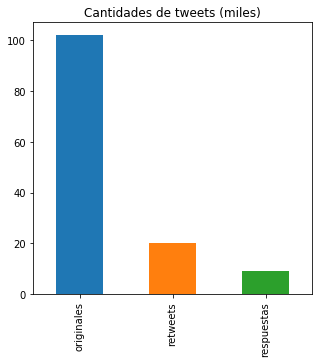

In [14]:
df_cutted = df_cut1
print_dataset_proportions(df_cutted)

### 2 Promedio de conteos de retweets (usando retweet_count de la API de twitter)

In [15]:
def print_global_retweet_counts(data_f):
    avg_retweets_all = data_f.retweet_count.mean()
    print('Promedio de retweet counts (todo el dataset): \t\t{}'.format(avg_retweets_all))

    avg_retweets_nort = df_not_rt(data_f).retweet_count.mean()
    print('Promedio de retweet counts (solo tweets originales): \t{}'.format(avg_retweets_nort))

    # as retweets may point to the same tweet, we drop duplicates keeping the most updated one (oldest)
    avg_retweets_onlyrt =  df_only_rt(data_f).sort_values('created_at').drop_duplicates('retweeted_status__id_str', keep='last')\
        .retweet_count.mean()
    print('Promedio de retweet counts (solo retweets): \t\t{}'.format(avg_retweets_onlyrt))

### 2.0 Promedio de conteos de retweets (Global)

In [16]:
print_global_retweet_counts(df)

Promedio de retweet counts (todo el dataset): 		287.8567748937076
Promedio de retweet counts (solo tweets originales): 	21.598015277655204
Promedio de retweet counts (solo retweets): 		402.5140546068739


### 2.1 Promedio de conteos de retweets (Recorte 1)

In [17]:
df_cutted = df_cut1
print_global_retweet_counts(df_cutted)

Promedio de retweet counts (todo el dataset): 		281.0995642273226
Promedio de retweet counts (solo tweets originales): 	21.598015277655204
Promedio de retweet counts (solo retweets): 		616.0203196347032


# Recorte 2: tomar sólo usuarios para los que se trajo el máximo de tweets por fetch_timeline

[Aquí](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) se puede ver que 3,200 es el máximo de tweets que se puede traer. Se filtra entonces los usuarios para los cuales se extrajo esa cantidad de tweets.

Se usará 'Recorte 2' para referirse a esa filtrado de tweets

In [18]:
def df_cut2(data_f, max_tweets=3200):
    _df_tweets_per_user = data_f.user__id_str.groupby(data_f.user__id_str).count()
    data_f['user_tweets_on_dataset'] = _df_tweets_per_user[data_f.user__id_str.values].values
    return data_f[data_f.user_tweets_on_dataset >= max_tweets]


### 3 Ventanas de tiempo recogidas

In [19]:
def print_time_windows(data_f):
    print('Tweet más temprano en el tiempo: \t{}'.format(data_f.created_at.min()))
    print('Tweet más tardío en el tiempo: \t\t{}'.format(data_f.created_at.max()))

    max_of_mins = data_f.created_at.groupby(data_f.user__id_str).min().max()
    print('Menor fecha de tweet disponible para todos los usuarios: {}'.format(max_of_mins))
    
    min_of_maxs = data_f.created_at.groupby(data_f.user__id_str).max().min()
    print('Mayor fecha de tweet disponible para todos los usuarios: {}'.format(min_of_maxs))

### 3.0 Ventanas de tiempo recogidas (Global)

In [20]:
print_time_windows(df)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-10-30 23:59:56
Menor fecha de tweet disponible para todos los usuarios: 2018-10-30 23:39:04
Mayor fecha de tweet disponible para todos los usuarios: 2018-10-28 00:01:01


### 3.1 Ventanas de tiempo recogidas (Recorte 1)

In [21]:
df_cutted = df_cut1
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-10-30 23:59:56
Menor fecha de tweet disponible para todos los usuarios: 2018-10-30 23:53:15
Mayor fecha de tweet disponible para todos los usuarios: 2018-10-28 00:01:01


### 3.2 Ventanas de tiempo recogidas (Recorte 2)

In [22]:
df_cutted = df_cut2(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	NaT
Tweet más tardío en el tiempo: 		NaT
Menor fecha de tweet disponible para todos los usuarios: NaT
Mayor fecha de tweet disponible para todos los usuarios: NaT


In [23]:
tweets_on_tweet_limit = df_cutted.shape[0]
users_on_tweet_limit = df_cutted.user__id_str.value_counts().count()
print('Tweets que tienen (igual) o más que el límite de tweets: {}'.format(tweets_on_tweet_limit))
print('Users que tienen (igual) o más que el límite de tweets: {}'.format(users_on_tweet_limit))

Tweets que tienen (igual) o más que el límite de tweets: 0
Users que tienen (igual) o más que el límite de tweets: 0


### 4 Histograma de tweets y retweets por fecha

In [24]:
def plot_tweets_and_retweets_by_date(data_f):
    print('Valores a plotear: {}'.format(data_f.shape[0]))
    fig, ax = plt.subplots(figsize=(10,5))
    (data_f.created_at.groupby(data_f["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Todos los tweets')
    (data_f.created_at.groupby(df_only_rt(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo RT')
    (data_f.created_at.groupby(df_commented(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo con commentarios')
    ax.set_title('Histograma de tweets por fecha')
    ax.set_ylabel('cantidad (miles)')
    ax.set_xlabel('fecha')

### 4.0 Histograma de tweets y retweets por fecha (Global)

Valores a plotear: 145589


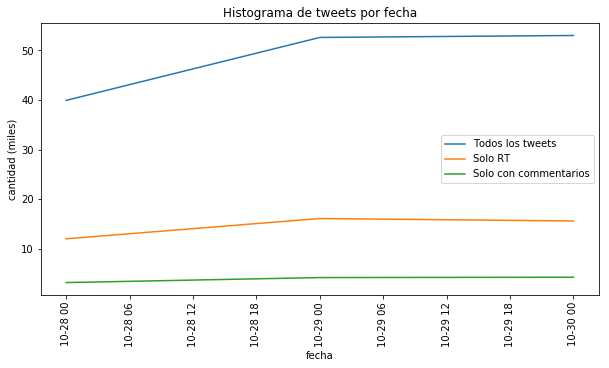

In [25]:
plot_tweets_and_retweets_by_date(df)

### 4.1 Histograma de tweets y retweets por fecha (Recorte 1)

Valores a plotear: 122082


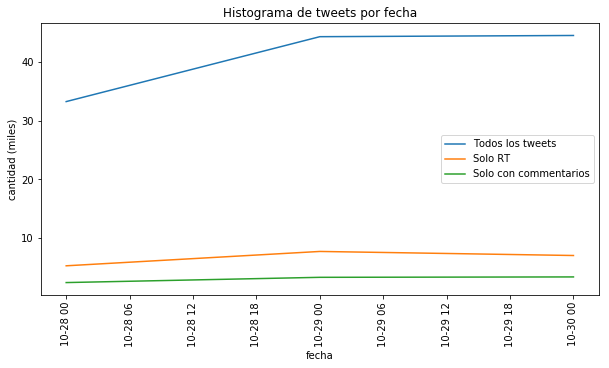

In [26]:
df_cutted = df_cut1
plot_tweets_and_retweets_by_date(df_cutted)

### 4.2 Histograma de tweets y retweets por fecha (Recorte 2)

Valores a plotear: 0
Empty 'DataFrame': no numeric data to plot


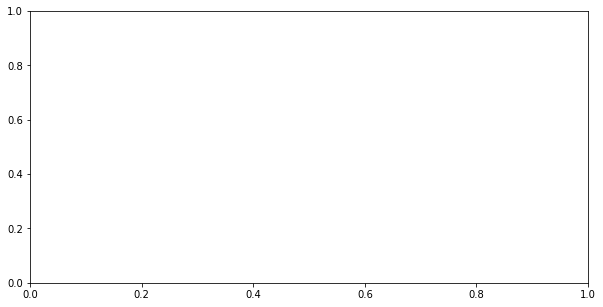

In [27]:
try:
    df_cutted = df_cut2(df)
    plot_tweets_and_retweets_by_date(df_cutted)
except Exception as e:
    print(e)

### 5 Histograma de tweets y retweets por hora

Nota: se dejan afuera las primeras n horas por exceder los ordenes de magnitud para el ploteo

In [28]:
def plot_retweets_per_hour(data_f):
    data_f = data_f.copy()
    data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
    # agregar columna de primer aparicion en el dataset (created at oo si es RT, primer RT en el grupo)
    counts_per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
    
    def _find_first_n_outliers():
        head = counts_per_hour[0]
        for i in range(1, len(counts_per_hour)):
            if head < 2 * counts_per_hour[i]:
                break
            head = counts_per_hour[i]
        return i
    n_head_outliers = _find_first_n_outliers()
    first_n_hours_considered = 56

    print('Begin Outliers:')
    print(counts_per_hour.head(n_head_outliers))
    print('End Outliers:')
    print('Hay {} valores a plotear'.format(counts_per_hour.count()))
    counts_per_hour.head(first_n_hours_considered)[n_head_outliers:].plot(kind="line")

### 5.0 Histograma de tweets y retweets por hora (Global)

Begin Outliers:
time_diff
0.0    17781
1.0     5765
Name: time_diff, dtype: int64
End Outliers:
Hay 688 valores a plotear


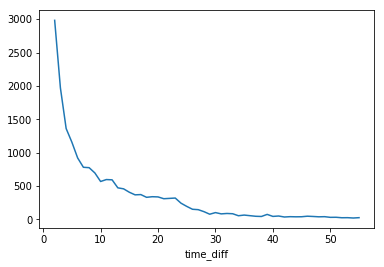

In [29]:
counts = plot_retweets_per_hour(df)

### 5.1 Histograma de tweets y retweets por hora (Recorte 1)

Begin Outliers:
time_diff
0.0    9580
1.0    2157
Name: time_diff, dtype: int64
End Outliers:
Hay 62 valores a plotear


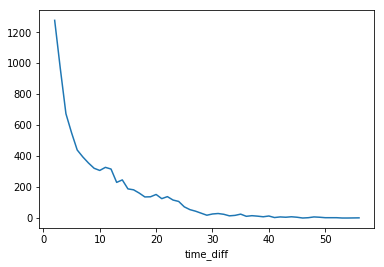

In [30]:
df_cutted = df_cut1
counts = plot_retweets_per_hour(df_cutted)

### 5.2 Histograma de tweets y retweets por hora (Recorte 2)

In [31]:
try:
    df_cutted = df_cut2(df)
    counts = plot_retweets_per_hour(df_cutted)
except Exception as e:
    print(e)

0.0


### Retweets por hora de n tweets más retweeteados (en el dataset)

In [32]:
def annotate_df_with_rt_on_dataset(data_f):
    # dict-like series: key = retweeted_status__id_str  -> value = how many times was RTed in dataset
    _df_tweets_per_user = data_f.retweeted_status__id_str.groupby(data_f.retweeted_status__id_str).count()
    # add key for NaNs -> to be set to 0
    _df_tweets_per_user.loc['-1'] = 0
    # get data frame's retweeted_status__id_str field for completition.
    a = data_f.retweeted_status__id_str.fillna('-1').values
    # update Retweets
    data_f['rt_on_dataset'] = _df_tweets_per_user[a].values
    # update only original tweets # TODO

def get_top_retweeted(data_f, n=5):
    annotate_df_with_rt_on_dataset(data_f)
    top_retweeted = data_f.drop_duplicates('rt_on_dataset').nlargest(5, 'rt_on_dataset', keep='last')
    return top_retweeted.head(n)

def plot_tweets_per_hour(t_id, use_percentage=False):
    """For single tweet"""
    data_f = df[df.retweeted_status__id_str == str(t_id)]
    total = data_f.iloc[0].rt_on_dataset
    data_f['time_diff'] = data_f.created_at - data_f.retweeted_status__created_at

    # filter on max_hour ? TODO
    per_hour = (data_f.time_diff.groupby((data_f.time_diff / np.timedelta64(1, 'h')).round(0)).count())
    if use_percentage:
        per_hour = per_hour / total

    fig, axes = plt.subplots(ncols=2)
    per_hour.plot(kind="line", ax=axes[0],figsize=(15, 4))
    axes[0].set_title('Histograma de RT por hora a partir del tweet')
    axes[0].set_ylabel('cantidad')
    axes[0].set_xlabel('hora')
    per_hour.cumsum().plot(kind='line', ax=axes[1])
    axes[1].set_title('Histograma de RT por hora a partir del tweet acumulado')
    axes[1].set_ylabel('cantidad')
    axes[1].set_xlabel('hora')

RTs to be plotted for df: 87


/home/emanuel/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RTs to be plotted for df: 77
RTs to be plotted for df: 66
RTs to be plotted for df: 54
RTs to be plotted for df: 50


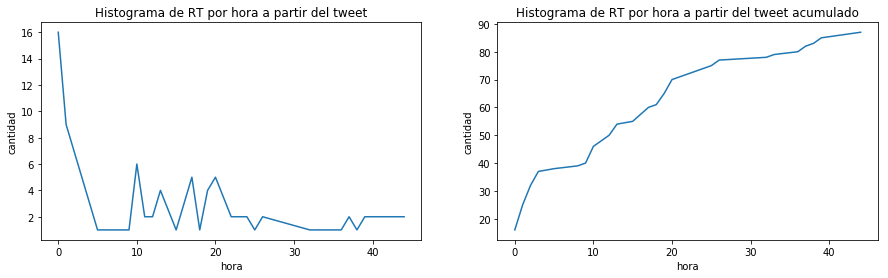

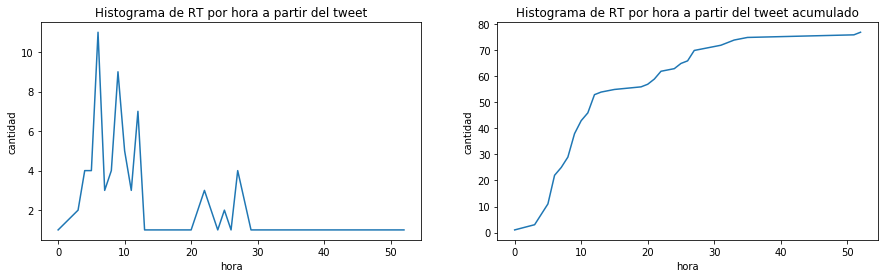

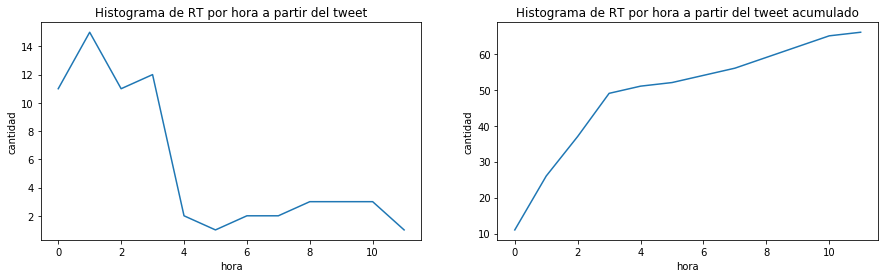

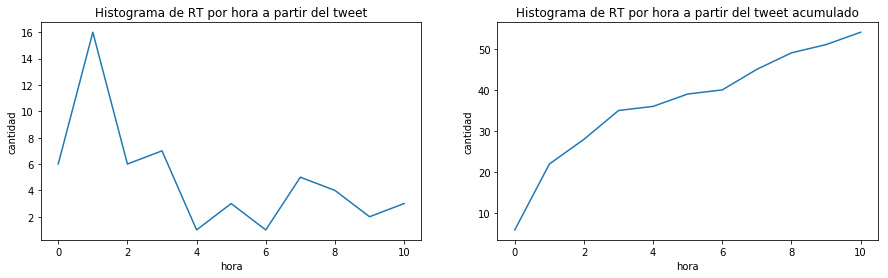

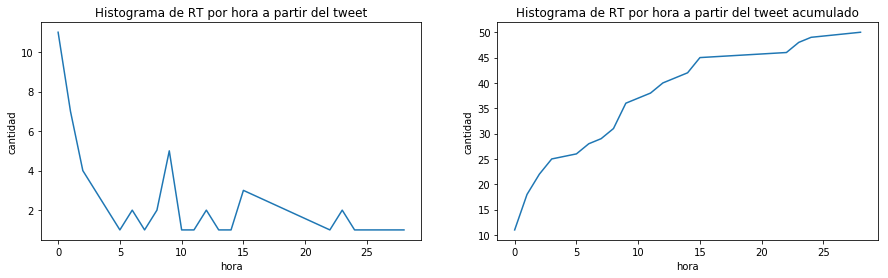

In [33]:
top_retweeted = get_top_retweeted(df)
for t_id in top_retweeted.retweeted_status__id_str:
    retweeted = df[df.retweeted_status__id_str == str(t_id)]
    print('RTs to be plotted for df: {}'.format(retweeted.shape[0]))
    plot_tweets_per_hour(t_id, use_percentage=False)

### Retweets por hora en general (porcentajes)

(-1, 50)

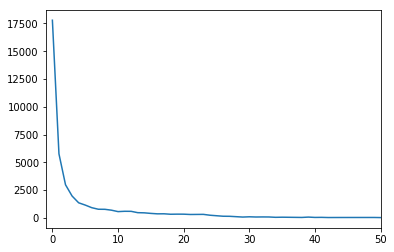

In [34]:
data_f = df.copy()
annotate_df_with_rt_on_dataset(data_f)
data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
plt.plot(per_hour, linestyle='solid')
plt.xlim(-1, 50)

(-1, 10)

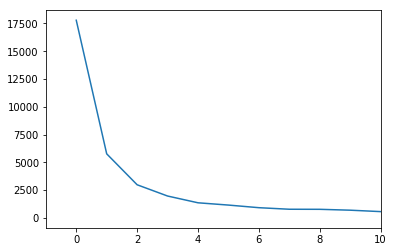

In [35]:
plt.plot(per_hour, linestyle='solid')
plt.xlim(-1, 10)

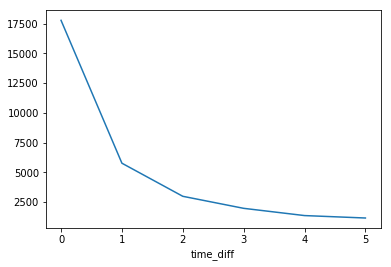

In [36]:
per_hour[per_hour >= 1000].plot()

### Plot cuartiles de retweets

In [37]:
def annotate_df_with_rt_on_dataset_til_x(data_f, label, time_limit=None):
    # filter on time limit
    # time_limit should be type np.timedelta64()
    data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
    if time_limit:
        df_filt = data_f[data_f.time_diff < time_limit]
    # dict-like series: key = retweeted_status__id_str  -> value = how many times was RTed in dataset
    _df_tweets_per_user = df_filt.retweeted_status__id_str.groupby(df_filt.retweeted_status__id_str).count()
    # add key for NaNs -> to be set to 0
    _df_tweets_per_user.loc['-1'] = 0
    # get data frame's retweeted_status__id_str field for completition.
    a = data_f.retweeted_status__id_str.fillna('-1').values
    # update Retweets
    data_f[label] = _df_tweets_per_user[a].values
    return data_f

def annotate_quartiles_to_limit(data_f, limit=240, steps=4):
    step = int(limit / steps)
    label = 'rts_to_{}'.format(limit)
    data = [(step, label)]
    df_annotd = annotate_df_with_rt_on_dataset_til_x(df_test, label, time_limit=np.timedelta64(limit, 'm'))
    for i in range(steps-1):
        limit -= step
        label = 'rts_to_{}'.format(limit)
        data.append((step, label))
        df_annotd = annotate_df_with_rt_on_dataset_til_x(df_test, label, time_limit=np.timedelta64(limit, 'm'))
    return data_f, data


(0, 1)

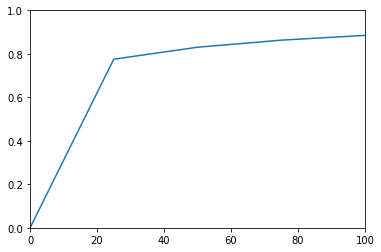

In [38]:
df_test = df_cut1.copy(deep=True)
steps = 4
limit = 300  # 5 hs in minutes
df_test, data = annotate_quartiles_to_limit(df_test, steps=steps, limit=limit)
annotate_df_with_rt_on_dataset(df_test)
to_plot = df_test[df_test.retweeted_status__id_str.notna()].drop_duplicates('retweeted_status__id_str')
# get averages
cols = [y for (x, y) in data]
max_value = cols[0]
for col in cols:
    to_plot['perc_' + col] = to_plot[col] / to_plot.rt_on_dataset
# plot results
y_s = []
for (_, col) in data:
    y_s.append(to_plot['perc_' + col].mean())
x_s = list(range(0, 101, int(100/steps)))
y_s =  [0] + list(reversed(y_s))
plt.plot(x_s, y_s, linestyle='solid')
plt.xlim(0, 100)
plt.ylim(0, 1)

In [48]:
cols_to_omit = ['quoted_status_id_str', 'text', 'retweet_count', 'retweeted_status__old_created_at',
               'retweeted_status__old_user__id_str', 'retweeted_status__old_id_str',
                'retweeted_status__new_created_at', 'retweeted_status__new_id_str',
                'retweeted_status__new_user__id_str']
df_test[ [x for x in list(df_test.columns) if x not in cols_to_omit] ]
to_plot[ [x for x in list(to_plot.columns) if x not in cols_to_omit] ]# list(df_test.columns)
print("mem_usg in megas: {}".format(sum(df.memory_usage()) / 1000000))
print(df.memory_usage())

mem_usg in megas: 11.6472
Index                                  80
created_at                        1164712
user__id_str                      1164712
id_str                            1164712
retweeted_status__id_str          1164712
retweeted_status__user__id_str    1164712
retweeted_status__created_at      1164712
retweet_count                     1164712
quoted_status_id_str              1164712
user_tweets_on_dataset            1164712
rt_on_dataset                     1164712
dtype: int64
